In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from typing import List
from typing import Tuple
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
df = pd.read_csv('processed.cleveland.csv', header=None)
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 
                'oldpeak', 'slope', 'ca', 'thal', 'num']
df.columns = column_names


In [3]:
def preprocess_data(df: pd.DataFrame, column_names: List[str]) -> pd.DataFrame:

    df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
    df['thal'] = pd.to_numeric(df['thal'], errors='coerce')

    df['ca'] = df['ca'].fillna(df['ca'].median())
    df['thal'] = df['thal'].fillna(df['thal'].median())

    df['num'] = np.where(df['num'] >= 2, 1, df['num'])

    return df
df = preprocess_data(df, column_names)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from typing import Tuple

def train_model(df: pd.DataFrame) -> Tuple[str, DecisionTreeClassifier]:
    X = df.drop('num', axis=1)
    y = df['num']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = DecisionTreeClassifier(
        class_weight='balanced',
        max_features=10, 
        splitter='best',  
        max_depth=7, 
        random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    
    return report, model

report, model = train_model(df)

print(report)

              precision    recall  f1-score   support

           0       0.70      0.73      0.71        48
           1       0.68      0.65      0.67        43

    accuracy                           0.69        91
   macro avg       0.69      0.69      0.69        91
weighted avg       0.69      0.69      0.69        91



using class_weight=balanced helped the model balance out by giving weight to the minority class. using max_features to ten makes sure that the chance of over-fitting is very small. spitter= best allows the model to choose the optimal split at each node so the data is accurate max_depth=7 stops the tree from growing to much. 

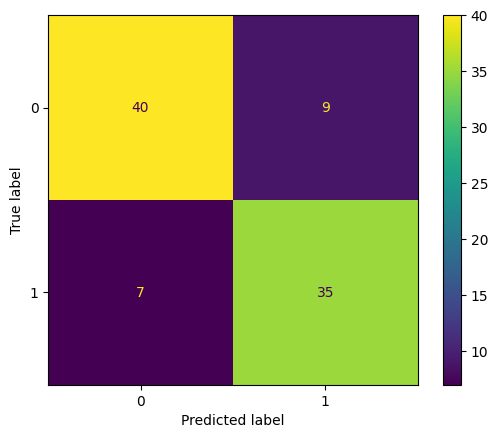

In [5]:
def train_RandomForest_model(df: pd.DataFrame) -> Tuple[float, RandomForestClassifier]:
    X = df.drop('num', axis=1)
    y = df['num']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    RandomForest = RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_split=3,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42)
    
    RandomForest.fit(X_train, y_train)
    
    score = RandomForest.score(X_test, y_test)
    
    ConfusionMatrixDisplay.from_estimator(RandomForest, X_test, y_test)
    
    return score, RandomForest

score, RandomForest = train_RandomForest_model(df)


In [6]:
35/(35+7)

0.8333333333333334

n_estimatots are the number of trees in forests max_depth is the maximum number of trees to prevent over-fitting
min samples split is the minimum samples required to split an node min sample leaf is samples required to be a leaf node class weight= balanced adjust weights so the class can handle it. the model did pretty well.

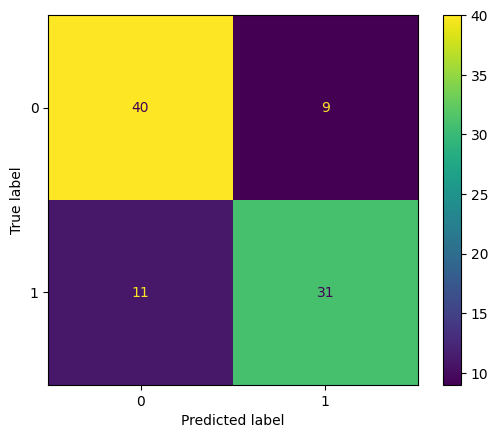

In [ ]:
def train_xgb_model(df: pd.DataFrame) -> Tuple[XGBClassifier, pd.Series]:
    X = df.drop('num', axis=1)
    y = df['num']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=10,
        subsample=1,
        gamma=1,
        scale_pos_weight=1,
    )    
    xgb.fit(X_train, y_train)
    
    y_pred = xgb.predict(X_test)
    
    ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
    
    return xgb, y_pred

xgb, y_pred = train_xgb_model(df)

In [ ]:
31/(31+11)

0.7380952380952381

the parameters that i used were n_estimators=300, and max_depth=10 from before i added subsample to help prevent over-fitting and i added gamma to help split the trees and minimize loss reduction. scale_pos_weight helpled balance the classes. 
